
#Baseline model

This is the implementation of the baseline model of the CS466 project.



##Data preparation

First, merge all the DNA file under the ``./data`` into one file ``dnas.fasta``

Then load the data.

In this project, we implement our method based on the following species.
1. primates: Homo sapiens (Human), Macaca mulatta, Macaca fascicularis, gorilla, Macaca nemestrina

2. mammals: Bos taurus, Sus scrofa, Canis lupus familiaris, Peromyscus leucopus, Peromyscus maniculatus bairdii


In [ ]:
def import_fasta(nom):
    dna={}
    o = open(nom,'r')
    r = o.read()
    lines = r.split("\n\n")
    for line in lines:
        line_split =line.split("\n",1)
        name= line_split[0]
        seq = line_split[1].strip()
        dna[name] = seq
    return dna

DNA = import_fasta('dnas.fasta')

for D in DNA:
    print(D)
    print(DNA[D])

##MSA

In [34]:
def compute_profile(alignment, alphabet):
    """
    Given an alphabet an a multiple sequence alignment in that alphabet,
    computes and returns its profile representation
    
    :param: alignment is a list of lists of characters in the alphabet
    :param: alphabet is a list of characters in the alphabet from which the strings are
            constructed
    :return: a dictionary where dict[x][i] is the frequency of the character
             x in the i-th position of the alignment.
    """
    
    if not alignment:
        return {}

    n = len(alignment)
    l = len(alignment[0])
    profile = {}

    # YOUR CODE HERE
    for i in range(len(alphabet)):
      profile[alphabet[i]] = []
      for j in range(l):
        freq = 0.0
        for c in range(n):
          if(alignment[c][j] == alphabet[i]):
            freq = freq+1
        profile[alphabet[i]].append(freq/n)
    #raise NotImplementedError()
    return profile

In [35]:
def compute_tau(profile, alphabet, delta):
    """
    Given a profile, an alphabet and a scoring function for that alphabet,
    returns the scoring function for aligning a character in the alphabet
    to a column in the profile
    
    :param: profile is the profile representation of the multiple sequence
            we are aligning against
    :param: alphabet is the alphabet of characters that compose our sequences
    :param: delta is the scoring function between characters in our alphabet
    
    :return: The scoring function tau such that tau[x][i] is the score for aligning
             character x with column i of the profile.
    """
    tau = {}
    # YOUR CODE HERE
    for x in range(len(alphabet)):
      tau[alphabet[x]] = []
      for j in range(len(profile[alphabet[i]])):
        score = 0.0
        for y in range(len(alphabet)):
          score = score+profile[alphabet[y]][j]*delta[alphabet[x]][alphabet[y]]
        tau[alphabet[x]].append(score)
    #print(tau)
    return tau

In [36]:
UP = (-1, 0)
LEFT = (0, -1)
TOPLEFT = (-1, -1)

def traceback(aln1, aln2, pointers):
    i = len(aln1[0])-1
    j = len(aln2[0])-1
    new_al1 = [list(v) for v in aln1]
    new_al2 = [list(w) for w in aln2]
    while True:
        di, dj = pointers[i][j]
        if (di, dj) == LEFT:
            for seq1 in new_al1:
                seq1.insert(i, '-')
        if (di, dj) == UP:
            for seq2 in new_al2:
                seq2.insert(j, '-')
        i, j = i + di, j + dj
        if (i <= 0 and j <= 0):
            break
    new_alignment = []
    for seq in new_al1:
        new_alignment.append(''.join(seq))
    for seq in new_al2:
        new_alignment.append(''.join(seq))
    return new_alignment


def align_sequence_profile(alignment, sequence, alphabet, delta):
    """
    This function aligns a sequence against a multiple sequence alignment
    
    :param: alignment is the multiple sequence alignment are aligning against.
            This is a list of list of characters
    :param: sequence is the new sequence we are aligning to the multiple alignment.
            This is a list of characters
    :param: alphabet is a list of characters that could compose the sequences in
            the alignments.
    :param: delta is the scoring function for aligning characters in our alphabet.
            delta[x][y] is the score for aligning the characters x and y.
    
    
    :return: a list of lists of characters in the alphabet, representing the 
             new multiple sequence alignment
    """
    # Base case when there is an empty multiple alignment
    if not alignment:
        return [sequence]
    M = [[0 for _ in range(len(alignment[0]))] for _ in range(len(sequence))] 
    pointers = [[(0,0) for _ in range(len(alignment[0]))] for _ in range(len(sequence))]
    score = None
    
    profile = compute_profile(alignment, alphabet)
    tau = compute_tau(profile, alphabet, delta)

    for i in range(len(sequence)):
        for j in range(len(alignment[0])):
            if i == 0 and j == 0:   
                M[i][j] = 0
            elif i == 0:
                M[i][j] = M[i][j-1] + tau['-'][j-1]
                pointers[i][j] = LEFT
            elif j == 0:
                sequence[i-1]
                M[i][j] = M[i-1][j] + delta[sequence[i-1]]['-']
                pointers[i][j] = UP
            else:
                best_sub = max([(LEFT, M[i][j-1] + tau['-'][j-1]), 
                               (UP, M[i-1][j] + delta[sequence[i-1]]['-']), 
                               (TOPLEFT, M[i-1][j-1] + tau[sequence[i-1]][j-1])], key = lambda x: x[1])
                pointers[i][j] = best_sub[0]
                M[i][j] = best_sub[1]

    score = M[-1][-1]
    return score, traceback([sequence], alignment, pointers)

In [37]:
def compute_sigma(p,q,alphabet, delta):
    """
    :param: p is the profile for the first multiple alignment
    :param: q is the profile for the second multiple alignment
    :param: alphabet is the list of all characters in our sequences
    :param: delta is the scoring function for aligning characters in our alphabet
    
    :returns: a list of lists sigma such that sigma[i][j] is the score for aligning column
              i of p with column j of q
    """
    sigma = []
    size_p = len(p[alphabet[0]])
    size_q = len(q[alphabet[0]])
    # YOUR CODE HERE
    #raise NotImplementedError()
    for i in range(size_p):
      scores = []
      for j in range(size_q):
        s = 0.0
        for x in range(len(alphabet)):
          for y in range(len(alphabet)):
            s = s+p[alphabet[x]][i]*q[alphabet[y]][j]*delta[alphabet[x]][alphabet[y]]
        scores.append(s)
      sigma.append(scores)

    return sigma

In [38]:
UP = (-1, 0)
LEFT = (0, -1)
TOPLEFT = (-1, -1)

def traceback(aln1, aln2, pointers):
    i = len(aln1[0])
    j = len(aln2[0])
    new_al1 = [list(v) for v in aln1]
    new_al2 = [list(w) for w in aln2]
    while True:
        di, dj = pointers[i][j]
        if (di, dj) == LEFT:
            for seq1 in new_al1:
                seq1.insert(i, '-')
        if (di, dj) == UP:
            for seq2 in new_al2:
                seq2.insert(j, '-')
        i, j = i + di, j + dj
        if (i <= 0 and j <= 0):
            break
    new_alignment = []
    for seq in new_al1:
        new_alignment.append(''.join(seq))
    for seq in new_al2:
        new_alignment.append(''.join(seq))
    return new_alignment

def align_profile_profile(aln1, aln2, alphabet, delta):
    """
    :param: aln1 is a list of lists representing the first multiple alignment
    :param: aln2 is a list of lists representing the second multiple alignment
    :param: alphabet is the alphabet from which the sequences are derived
    :param: delta is a scoring function. delta(x,y) gives us the score for aligning 
            character x with character y in our alphabet
            
    :returns: the optimal score and the optimal multiple alignment for the two input alignments.
    """
    # Base case when there is an empty multiple alignment
    if not aln1 and not aln2:
        return []
    elif not aln2:
        return aln1
    elif not aln1:
        return aln2
    
    S = [[0 for j in range(len(aln2[0])+1)] for i in range(len(aln1[0])+1)] 
    pointers = [[(0,0) for j in range(len(aln2[0])+1)] for i in range(len(aln1[0])+1)]
    score = None
    
    # Compute profiles and scoring functions here
    p = compute_profile(aln1, alphabet)
    q = compute_profile(aln2, alphabet)
    tau1 = compute_tau(p, alphabet, delta)
    tau2 = compute_tau(q, alphabet, delta)
    sigma = compute_sigma(p,q,alphabet, delta)

    # YOUR CODE HERE
    #raise NotImplementedError()
    for i in range(len(aln1[0])+1):
      for j in range(len(aln2[0])+1):
        if i == 0 and j == 0:   
          S[i][j] = 0
        elif i == 0:
          S[i][j] = S[i][j-1] + tau2['-'][j-1]
          pointers[i][j] = LEFT
        elif j == 0:
          S[i][j] = S[i-1][j] + tau1['-'][i-1]
          pointers[i][j] = UP
        else:
          best_sub = max([(LEFT, S[i][j-1] + tau2['-'][j-1]), 
                          (UP, S[i-1][j] +tau1['-'][i-1]), 
                          (TOPLEFT, S[i-1][j-1] + sigma[i-1][j-1])], key = lambda x: x[1])
          pointers[i][j] = best_sub[0]
          S[i][j] = best_sub[1]
         
    score = S[-1][-1]

    return score, traceback(aln1, aln2, pointers)
    

In [39]:
def greedy_progressive_align(alignments, alphabet, delta):
    """
    :param: alignments is a list of list of strings representing the sequences to be aligned
            Note: This is because we need to represent our single sequences as multiple alignments
            ,and multiple alignments are lists of strings
    :param: alphabet is the alphabet from which the sequences are derived
    :param: delta is a scoring function. delta(x,y) gives us the score for aligning 
            character x with character y in our alphabet
            
    :returns: the greedy optimal multiple sequence alignment for a given set of sequences, and the score for that alignment
    """
    
    
    while True: 
        # Base case (When to exit the loop?)
        # YOUR CODE HERE
        if(len(alignments)==1):
          return alignments
        if(len(alignments)==2):
          score, best_alignment = align_profile_profile(alignments[1], alignments[0], alphabet, delta)
          #print(best_alignment)

          return score,best_alignment
        # Data structures for this iteration
        best_score = -float("inf")
        best_alignment = None
        best_m = -1
        best_n = -1

        # Compute pairwise distances 
        for m in range(len(alignments)):
            for n in range(m):
                # YOUR CODE HERE           
                temp_score,returned_alignment = align_profile_profile(alignments[m], alignments[n], alphabet, delta)
                if(temp_score >= best_score):
                  best_alignment = returned_alignment
                  best_m=m
                  best_n=n
        # Populate the list of alignments to use for the next iteration
        next_alignments = [best_alignment]
        for i in range(len(alignments)):
            if i!=best_m and i!=best_n:
                next_alignments.append(alignments[i])
        alignments = next_alignments
  
    

In [40]:
alphabet = ['A', 'C', 'G', 'T', '-']
delta = {}
for i in range(len(alphabet)):
    delta[alphabet[i]] = {k : v for (k,v) 
                          in zip(alphabet, [1 if alphabet[i] == alphabet[j]  else -1 
                                  for j in range(len(alphabet))]
                         )}
                         

Replace the ``test1_seq`` with your own sequence to construct the MSA and then store them to ``msa.phy`` file for the tree contruction and visualization.


In [41]:
test1_seqs = [['ATCT'],['AGCT']]

In [42]:
greedy_progressive_align(test1_seqs, alphabet, delta)

(2.0, ['AGCT', 'ATCT'])

##Neighbor Joining and Visualization

In [21]:
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 5.2 MB/s 


In [63]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
aln = AlignIO.read(open('msa.phy'), 'phylip')
print(aln)

Alignment with 10 rows and 2748 columns
--------------------TC---------A------------...--- cow
--------------------GG----------------------...--- macaqueP
--------------------CC---------A------------...--- gorilla
----------------AA--CC---------CTCC---------...--- macaqueL
G--------AAATGAT----CCGGAAATTG-C---AGCCT-CAG...--- macaqueR
---------A---G------CC---------C-------T-C--...--- Human
---------A----------CC---------A---------G--...--- DeerMouse
---------A----------CC---------A---------G--...CAA MouseW
----C----A----------CC---------C---------C--...--- Dog
-TGGCCCTCA--------GGCC--------GC--------TC--...--- WildPig


In [64]:
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(aln)
print(dm)

cow	0
macaqueP	0.289665211062591	0
gorilla	0.3227802037845706	0.05385735080058229	0
macaqueL	0.2947598253275109	0.01455604075691408	0.053493449781659375	0
macaqueR	0.39628820960698685	0.16339155749636103	0.18813682678311494	0.16157205240174677	0
Human	0.35989810771470165	0.13391557496360995	0.13973799126637554	0.13500727802037849	0.11426491994177579	0
DeerMouse	0.47707423580786024	0.28420669577874813	0.29949053857350805	0.28493449781659386	0.3260553129548762	0.29730713245997087	0
MouseW	0.4756186317321689	0.2838427947598253	0.2987627365356623	0.28457059679767105	0.3256914119359534	0.29621542940320233	0.01455604075691408	0
Dog	0.47161572052401746	0.30895196506550215	0.32350800582241634	0.3093158660844251	0.35152838427947597	0.32059679767103344	0.23435225618631728	0.23326055312954874	0
WildPig	0.5393013100436681	0.37190684133915575	0.3864628820960698	0.3726346433770015	0.41484716157205237	0.38755458515283847	0.27328966521106257	0.27292576419213976	0.20669577874818046	0
	cow	macaqueP	gori

In [65]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from Bio import Phylo
aln = AlignIO.read(open('msa.phy'), 'phylip')
constructor = DistanceTreeConstructor()
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(aln)
upgmatree = constructor.upgma(dm)
print(upgmatree)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner9')
        Clade(branch_length=0.10507641921397382, name='Inner8')
            Clade(branch_length=0.06159593340611355, name='Inner7')
                Clade(branch_length=0.0233806404657933, name='Inner6')
                    Clade(branch_length=0.10334788937409023, name='WildPig')
                    Clade(branch_length=0.10334788937409023, name='Dog')
                Clade(branch_length=0.11945050946142649, name='Inner1')
                    Clade(branch_length=0.00727802037845704, name='MouseW')
                    Clade(branch_length=0.00727802037845704, name='DeerMouse')
            Clade(branch_length=0.10781136280931589, name='Inner5')
                Clade(branch_length=0.020969796215429437, name='Inner4')
                    Clade(branch_length=0.057132459970887894, name='Human')
                    Clade(branch_length=0.057132459970887894, name='macaqueR')
                Clade(branch_length=0.051264556040756915, name='

In [66]:
njtree = constructor.nj(dm)
print(njtree)

Tree(rooted=False)
    Clade(branch_length=0, name='Inner8')
        Clade(branch_length=0.008170715065502217, name='Inner7')
            Clade(branch_length=0.03822666484716158, name='gorilla')
            Clade(branch_length=0.028662891193595337, name='Inner6')
                Clade(branch_length=0.013813076176613315, name='Inner5')
                    Clade(branch_length=0.11876819505094612, name='Inner3')
                        Clade(branch_length=0.04939956331877729, name='Inner2')
                            Clade(branch_length=0.1338116032439176, name='WildPig')
                            Clade(branch_length=0.07288417550426285, name='Dog')
                        Clade(branch_length=0.09343158660844253, name='Inner1')
                            Clade(branch_length=0.0069141193595341766, name='MouseW')
                            Clade(branch_length=0.007641921397379903, name='DeerMouse')
                    Clade(branch_length=0.037345342066957846, name='Inner4')
           

In [67]:
Phylo.draw_ascii(njtree)

   ______ gorilla
  |
  |                                       _________________________ WildPig
  |                              ________|
  |                             |        |_____________ Dog
 ,|        _____________________|
 ||       |                     |                 , MouseW
 ||       |                     |_________________|
 ||     __|                                       | DeerMouse
 ||    |  |
 ||    |  |       ______ Human
_||____|  |______|
 |     |         |_____________ macaqueR
 |     |
 |     |______________________________________________ cow
 |
 | macaqueP
 |
 | macaqueL



In [68]:
import matplotlib.pyplot as plt

In [69]:
import matplotlib

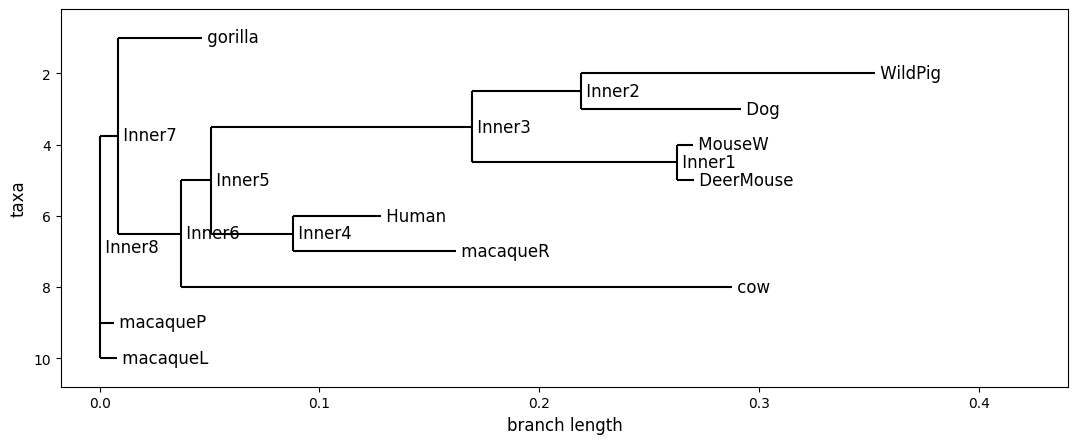

In [70]:
fig = plt.figure(figsize=(13, 5), dpi=100) # create figure & set the size 
matplotlib.rc('font', size=12)             # fontsize of the leaf and node labels 
matplotlib.rc('xtick', labelsize=10)       # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=10)       # fontsize of the tick labels
#turtle_tree.ladderize()		   # optional way to reformat your tree 
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(njtree, axes=axes)
fig.savefig("tree")